In [33]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, metrics
import numpy as np
from tensorflow.keras import models
from keras.regularizers import l2
from scipy import spatial
%reload_ext autoreload
%autoreload 2
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split

#!pip install kaggle
#!pip install --upgrade scikit-learn







In [ ]:
"""
import os
import requests
from tqdm import tqdm  # For progress bar

# URL of the dataset
url = "http://vis-www.cs.umass.edu/lfw/"

# Destination directory
dest_dir = "/root/scikit_learn_data/lfw_home/lfw.tgz"
# Destination file path
dest_file = os.path.join(dest_dir, "")

# Create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Download the file
response = requests.get(url, stream=True)
total_size_in_bytes = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 Kibibyte

progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
with open(dest_file, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()

if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    print("Error: Failed to download the dataset.")
else:
    print("LFW dataset downloaded successfully.")
"""

'\nimport os\nimport requests\nfrom tqdm import tqdm  # For progress bar\n\n# URL of the dataset\nurl = "http://vis-www.cs.umass.edu/lfw/"\n\n# Destination directory\ndest_dir = "/root/scikit_learn_data/lfw_home/lfw.tgz"\n# Destination file path\ndest_file = os.path.join(dest_dir, "")\n\n# Create destination directory if it doesn\'t exist\nif not os.path.exists(dest_dir):\n    os.makedirs(dest_dir)\n\n# Download the file\nresponse = requests.get(url, stream=True)\ntotal_size_in_bytes = int(response.headers.get(\'content-length\', 0))\nblock_size = 1024  # 1 Kibibyte\n\nprogress_bar = tqdm(total=total_size_in_bytes, unit=\'iB\', unit_scale=True)\nwith open(dest_file, \'wb\') as file:\n    for data in response.iter_content(block_size):\n        progress_bar.update(len(data))\n        file.write(data)\nprogress_bar.close()\n\nif total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:\n    print("Error: Failed to download the dataset.")\nelse:\n    print("LFW dataset downloaded

In [2]:
kaggle_api = {"username":"k213370ahmedmustafa","key":"0fa627b0c7030d201bece7295809fea9"}

import os

os.environ['KAGGLE_USERNAME'] = kaggle_api["username"]
os.environ['KAGGLE_KEY'] = kaggle_api["key"]


In [8]:
import os
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
# Set Kaggle API key
api.authenticate()

# Specify where to save the dataset
save_dir = "C:/Users/ahmed/scikit_learn_data/lfw_home"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Download the dataset
api.dataset_download_files("atulanandjha/lfwpeople", path=save_dir, unzip=True)

print("LFW dataset downloaded and extracted successfully.")


Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
LFW dataset downloaded and extracted successfully.


In [54]:
color  =True
import matplotlib.image as mpimg
lfw_train = fetch_lfw_people(min_faces_per_person=70, resize=0.8,color=color,funneled=True,download_if_missing=False,return_X_y=False)
X_train, X_val, y_train, y_val = train_test_split(lfw_train.images, lfw_train.target, test_size=0.3, random_state=42)
X_train = X_train.astype("float32")
#X_train /= 255.0
X_val = X_val.astype("float32")
#X_val/= 255.0

if color==True:
  IMG_SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
else:
  IMG_SHAPE = (X_train.shape[1], X_train.shape[2],1)


#print(X_train)

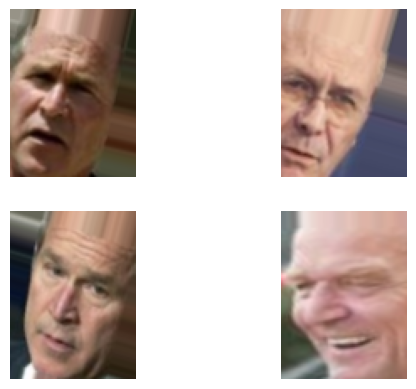

In [55]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example X_train array
# Ass # Dummy data for illustration

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotations within 20 degrees
    width_shift_range=0.2,  # Random horizontal shifts within 20% of the width
    height_shift_range=0.2, # Random vertical shifts within 20% of the height
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Zoom transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Filling strategy for new pixels
)

# Fit the data generator on your training data
datagen.fit(X_train)

# Generate augmented data
# To visualize the augmented data or use it in a training loop, you can use the .flow() method

# Example: Displaying augmented images
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images = datagen.flow(X_train, batch_size=4)

# Plot some augmented images
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_images[0][i])
    plt.axis('off')
plt.show()

In [56]:
lfw_pairs_test = fetch_lfw_pairs(subset="test", resize=0.8, color=color)
classes = list(lfw_pairs_test.target_names)
X_test = lfw_pairs_test.pairs
X_test = X_test.astype("float32")

if color==True:
  IMG_SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
else:
  IMG_SHAPE = (X_train.shape[1], X_train.shape[2])
print(IMG_SHAPE)

y_test = lfw_pairs_test.target

(100, 75, 3)


In [57]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(tf.abs(anchor - positive)), -1)
        an_distance = tf.reduce_sum(tf.square(tf.abs(anchor - negative)), -1)
        return (ap_distance, an_distance)

class SiameseNetwork():

    def __init__(self,
                 IMG_SHAPE,
                 cnn_filters=[64,64,128],
                 epochs=15,
                 lr=1e-4,
                 batch_size=128,
                 fine_tunning=False,
                 dropout_rate=0.3,
                 embedding_dim=64) -> None:
        self.IMG_SHAPE = IMG_SHAPE
        self.cnn_filters = cnn_filters
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.fine_tunning = fine_tunning
        self.dropout_rate = dropout_rate
        self.embedding_dim = embedding_dim
        self.model = None

    def get_embeddings(self):
      #embedding_model = self._get_embeddings_from_scratch()
        if self.fine_tunning is False:
            embedding_model = self._get_embeddings_from_scratch()
        else:
            embedding_model = self._get_fine_tunning_embeddings()

        return embedding_model

    def get_siamese_distance_siamese_network(self):
        anchor_input = layers.Input(shape=self.IMG_SHAPE, name='anchor_input')
        positive_input = layers.Input(shape=self.IMG_SHAPE, name='positive_input')
        negative_input = layers.Input(shape=self.IMG_SHAPE, name='negative_input')

        embedding_model = self.get_embeddings()

        # Generate the embeddings for the anchor, positive, and negative inputs
        anchor_embeddings = embedding_model(anchor_input)
        positive_embeddings = embedding_model(positive_input)
        negative_embeddings = embedding_model(negative_input)

        distances = DistanceLayer()(anchor_embeddings, positive_embeddings, negative_embeddings)

        self.model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name="Embedding")
        return self.model

    def train(self, generator):
        steps_per_epoch = self.batch_size
        history = self.model.fit(generator, steps_per_epoch=steps_per_epoch, batch_size=self.batch_size, epochs=self.epochs)
        return history

    def get_test_model(self, embedding_layer=None):
        if embedding_layer is None:
            embedding_layer = self.model.layers[3]

        anchor_input = tf.keras.Input(shape=self.IMG_SHAPE)
        anchor_embeddings = embedding_layer(anchor_input)
        embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
        return embedding_model

    def test(self, X_test, y_test, embedding_layer=None):
        embedding_model = self.get_test_model(embedding_layer)

        embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
        embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

        similarities = []
        for i in range(len(embedding1)):
            similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
            similarities.append(similarity)

        similarities = np.array(similarities)
        return similarities

    def _get_CNN(self):
        model = models.Sequential(name="CNN")

        for i in range(len(self.cnn_filters)):
            if i == 0:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), input_shape=self.IMG_SHAPE, activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            else:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            model.add(layers.BatchNormalization())
            model.add(layers.MaxPooling2D())
            model.add(layers.Dropout(self.dropout_rate))

        model.add(layers.Flatten())
        model.add(layers.Dense(self.embedding_dim, activation=None))

        return model

    def _get_embeddings_from_scratch(self):
        return self._get_CNN()

    def _get_fine_tunning_embeddings(self):
        input = layers.Input(shape=self.IMG_SHAPE)
        # Xception
        pretrained_model = Xception(
            input_shape=self.IMG_SHAPE,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )

        for i in range(len(pretrained_model.layers)-27):
            pretrained_model.layers[i].trainable = False

        processed = pretrained_model(input)

        flatten = layers.Flatten()(processed)
        x = layers.Dense(512, activation='relu')(flatten)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(self.embedding_dim, activation="relu")(x)
        embeddings = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
        siamese_network = models.Model(inputs=input, outputs=embeddings, name="Embedding")
        return siamese_network


# From Kaggle class
class SiameseModel(models.Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return tf.reduce_mean(loss)

    @property
    def metrics(self):
        return [self.loss_tracker]

In [58]:
def visualize(image0, image1, proba=None):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1), cmap='gray')
    if proba is not None:
        plt.suptitle("Distance: {:.2f}".format(proba))
    plt.show()


def triplet_data_generator(X, y, image_shape, max_size=None):
    total_size = max_size if max_size is not None else max(y)
    triplets = np.zeros((3, total_size, image_shape[0], image_shape[1],3))
    idx_to_delete = []

    for i in range(total_size):
        idx = i

        anchor_image = X[idx]
        anchor_label = y[idx]

        same_person = np.where(y == anchor_label)[0]
        if len(same_person) > 1:
            idx_i = np.isin(same_person, idx)
            same_person = np.delete(same_person, idx_i)
            positive_index = np.random.choice(same_person)
            negative_index = np.random.choice(np.where(y != anchor_label)[0])
            positive_image = X[positive_index]
            negative_image = X[negative_index]
            #visualize(anchor_image, positive_image)
            #visualize(anchor_image, negative_image)
            #print(anchor_image.shape)
            triplets[0][i] = anchor_image
            triplets[1][i] = positive_image
            #print(positive_image.shape)
            triplets[2][i] = negative_image
        else:
            idx_to_delete.append(i)
        # print("{percentage:.2f}%".format(percentage = (i * 100) / max(y)))

    triplets = np.delete(triplets, idx_to_delete, axis=1) # Remove people that doesn't have other photos of themself

    tmp = np.array([triplets[0,:], triplets[1,:], triplets[2,:]])
    tmp = np.transpose(tmp, (1, 0, 2, 3,4))
    return tmp

def get_batch(train_triplet, batch_size):
    num_batches = len(train_triplet) // batch_size

    for i in range(num_batches):
        batch = train_triplet[i * batch_size : (i + 1) * batch_size]
        anchor_imgs = batch[:, 0]
        positive_imgs = batch[:, 1]
        negative_imgs = batch[:, 2]
        targets = np.zeros(batch_size) # or generate the appropriate targets
        yield [anchor_imgs, positive_imgs, negative_imgs], targets

In [59]:
def visualize(image0, image1, image2):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1, image2], axis=1))
    plt.title("Anchor/Positive/Negative")
    plt.show()

def visualize_pair(image0, image1, similarity, label):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1))
    title = "Same person" if label == 1 else "Not same person"
    plt.title(title)
    if similarity is not None:
        plt.suptitle("Similarity: {:.2f}".format(similarity))

    plt.show()

def plot_training_loss(loss,val_loss):
    plt.plot(loss, label='training loss')
    plt.plot(val_loss,label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()


In [60]:
train_data = triplet_data_generator(X_train, y_train, IMG_SHAPE, 900)
len(train_data)

900

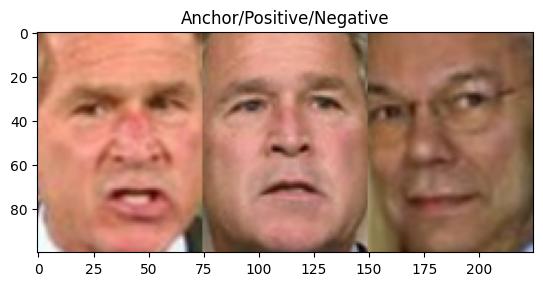

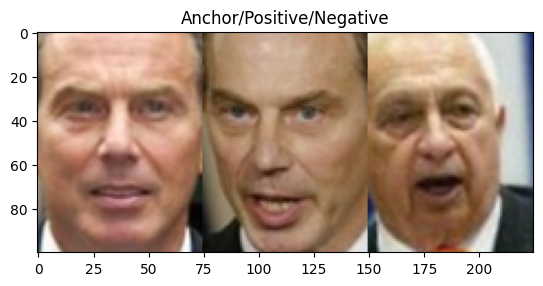

In [61]:
visualize(train_data[0][0], train_data[0][1], train_data[0][2])
visualize(train_data[1][0], train_data[1][1], train_data[1][2])

In [62]:
batch_size = 128
epochs = 15
lr = 1e-3
triplet_loss_margin = 1.0
fine_tunning = True
embedding_dim = 256

## Unused
dropout_rate = 0.4
cnn_filters = [64, 64, 128]
##

# Embedding part
sn = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, fine_tunning, dropout_rate, embedding_dim)
distances_model = sn.get_siamese_distance_siamese_network()
embedding_layer = distances_model.layers[3]

# Siamese Part
siamese_model = SiameseModel(distances_model, margin=triplet_loss_margin)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

#tf.keras.utils.plot_model(distances_model, show_shapes=True, to_file="images/architecture.png", show_layer_names=True)


In [63]:
loss_history = []
val_loss_history = []
min_val_loss = 100
for i in range(epochs):

    print("=================")
    print("Epoch", i)
    epoch_loss = []
    epoch_val_loss = []
    for batch, _ in get_batch(train_data, batch_size):
        loss = siamese_model.train_on_batch(batch)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    loss_history.append(epoch_loss)
    val_data = triplet_data_generator(X_val, y_val, IMG_SHAPE, 200)
    for val_batch,_ in get_batch(val_data,batch_size):
      val_loss = siamese_model.test_on_batch(val_batch)
      epoch_val_loss.append(val_loss)
    epoch_val_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    if(epoch_val_loss < min_val_loss):
      min_val_loss = epoch_val_loss
      embedding_layer.save_weights('embedding_layer.h5')
    val_loss_history.append(epoch_val_loss)
    print("Training Loss: ", epoch_loss)
    print("Validation Loss: ", epoch_val_loss)
    print("=================\n")

Epoch 0
Training Loss:  0.8723776510783604
Validation Loss:  0.6019859313964844

Epoch 1
Training Loss:  0.5358545993055616
Validation Loss:  0.48192018270492554

Epoch 2
Training Loss:  0.37411281040736605
Validation Loss:  0.31324106454849243

Epoch 3
Training Loss:  0.25483458595616476
Validation Loss:  0.22661089897155762

Epoch 4
Training Loss:  0.17832239185060775
Validation Loss:  0.19771724939346313

Epoch 5
Training Loss:  0.14949551863329752
Validation Loss:  0.22657756507396698

Epoch 6
Training Loss:  0.12296530976891518
Validation Loss:  0.13350257277488708

Epoch 7
Training Loss:  0.08018595246332032
Validation Loss:  0.1711270809173584

Epoch 8
Training Loss:  0.0746690843786512
Validation Loss:  0.25461047887802124

Epoch 9
Training Loss:  0.07886341586709023
Validation Loss:  0.2030474841594696

Epoch 10
Training Loss:  0.05815197740282331
Validation Loss:  0.14385001361370087

Epoch 11
Training Loss:  0.030975294166377614
Validation Loss:  0.049016259610652924

Epoch 

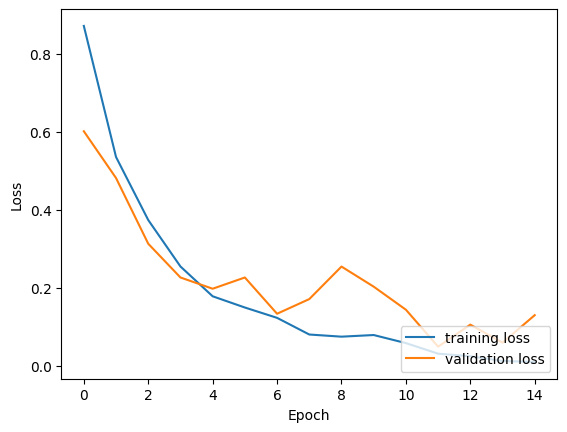

In [64]:
plot_training_loss(loss_history,val_loss_history)


In [66]:
# Load model

sn_new = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, True, dropout_rate, embedding_dim)
distances_model_new = sn_new.get_siamese_distance_siamese_network()
embedding_layer_new = distances_model_new.layers[3]


embedding_layer_new.load_weights('embedding_layer.h5')

In [67]:
from tensorflow.keras import models
from scipy import spatial

def get_test_model(embedding_layer, IMG_SHAPE):
    anchor_input = tf.keras.Input(shape=IMG_SHAPE)
    anchor_embeddings = embedding_layer(anchor_input)
    embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
    return embedding_model

def test(X_test, embedding_layer, IMG_SHAPE):
    embedding_model = get_test_model(embedding_layer, IMG_SHAPE)

    embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
    embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

    similarities = []
    for i in range(len(embedding1)):
        similarity =1 - spatial.distance.cosine(embedding1[i],embedding2[i])
        similarities.append(similarity)

    similarities = np.array(similarities)
    return similarities

In [68]:
similarities = test(X_test, embedding_layer, IMG_SHAPE)

32/32 [==============================] - 1s 25ms/step


In [69]:
not_same_people_idxs = similarities[y_test == 0]
same_people_idxs = similarities[y_test == 1]

avg_for_not_same_people = np.mean(not_same_people_idxs)
avg_for_same_people = np.mean(same_people_idxs)

classes = list(lfw_pairs_test.target_names)
print(classes[0], "(similarity mean)", avg_for_not_same_people)
print(classes[1], "(similarity mean)", avg_for_same_people)

threshold = (avg_for_not_same_people + avg_for_same_people) / 2
print("Threshold:", threshold)

binary_classification = np.zeros_like(similarities)
binary_classification[similarities >= threshold] = 1

accuracy = np.mean(binary_classification == y_test)
print("Accuracy:", accuracy)

Different persons (similarity mean) 0.4971747288731422
Same person (similarity mean) 0.6932472751336788
Threshold: 0.5952110020034105
Accuracy: 0.612


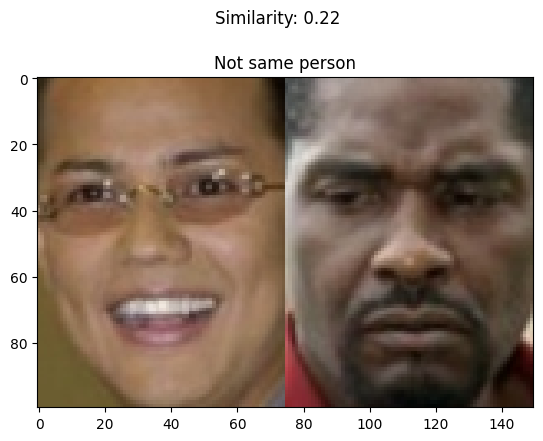

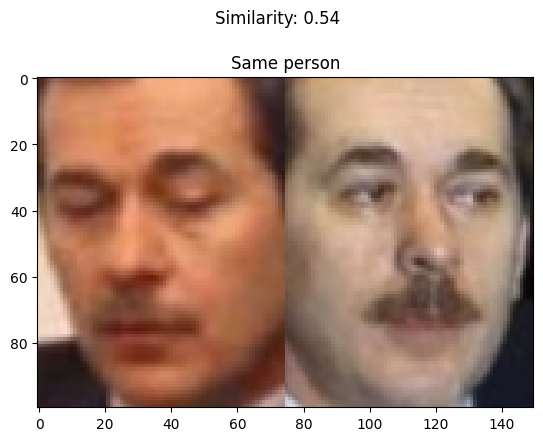

In [75]:
i = 650
j=2
visualize_pair(X_test[i][0], X_test[i][1], similarities[i], y_test[i])
visualize_pair(X_test[j][0], X_test[j][1], similarities[j], y_test[j])

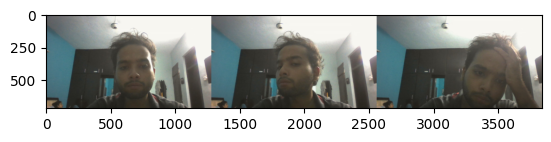

In [ ]:
import cv2

webcam1 = cv2.imread('/content/WIN_20240513_00_11_35_Pro.jpg')
webcam2 = cv2.imread('/content/WIN_20240513_00_11_43_Pro.jpg')
webcam3 = cv2.imread('/content/WIN_20240513_00_11_51_Pro.jpg')

# to RGB
webcam1 = cv2.cvtColor(webcam1, cv2.COLOR_BGR2RGB)
webcam2 = cv2.cvtColor(webcam2, cv2.COLOR_BGR2RGB)
webcam3 = cv2.cvtColor(webcam3, cv2.COLOR_BGR2RGB)
plt.imshow(np.concatenate([webcam1, webcam2, webcam3], axis=1))

Original shape (720, 1280, 3)
New shape (100, 75, 3)


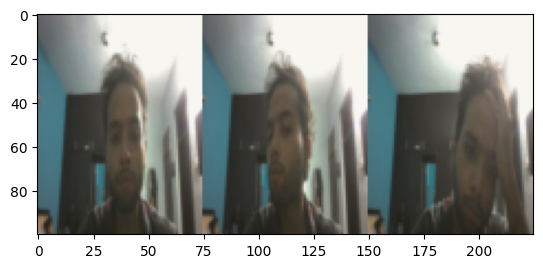

In [ ]:
from skimage.transform import resize

print("Original shape", webcam1.shape)

webcam1_resized = resize(webcam1, (100, 75)).astype("float32")
webcam2_resized = resize(webcam2, (100, 75)).astype("float32")
webcam3_resized = resize(webcam3, (100, 75)).astype("float32")
print("New shape", webcam1_resized.shape)
plt.imshow(np.concatenate([webcam1_resized, webcam2_resized, webcam3_resized], axis=1))

In [ ]:
def calc_similarity_and_plot(image1, image2, embedding_layer, IMG_SHAPE):
    data = np.array([[image1, image2]])
    similarity = test(data, embedding_layer, IMG_SHAPE)[0]
    label = 1 if similarity > threshold else 0
    visualize_pair(image1, image2, similarity, label)


Above 0.653268472489086 we consider the model classifying as same person
1/1 [==============================] - 0s 26ms/step


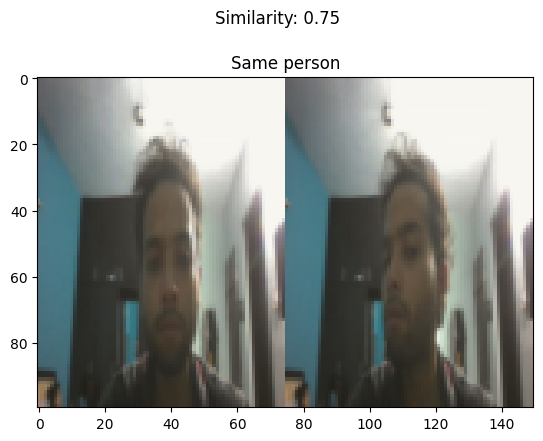

1/1 [==============================] - 0s 24ms/step


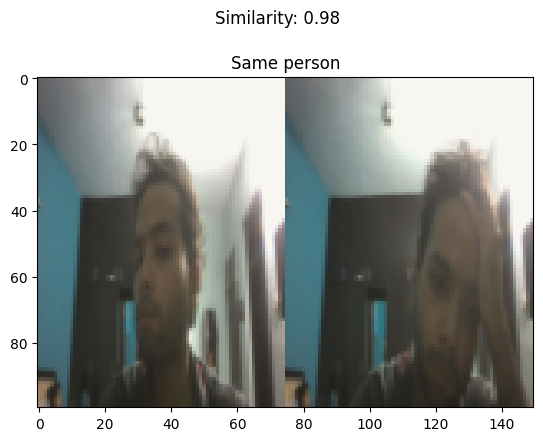

1/1 [==============================] - 0s 23ms/step


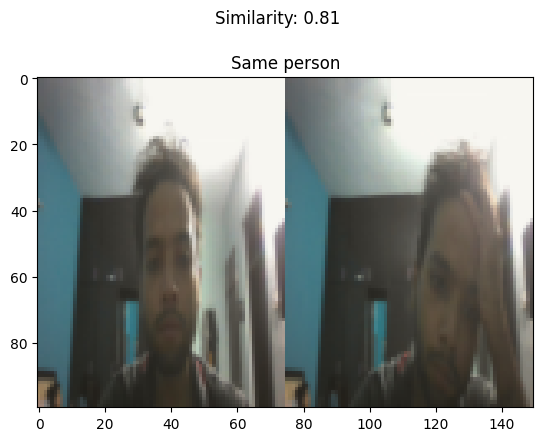

1/1 [==============================] - 0s 29ms/step


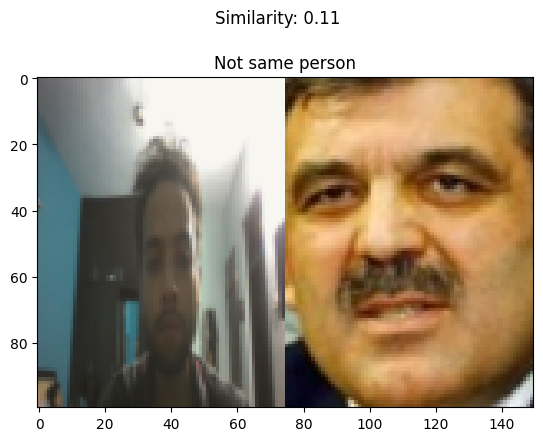

In [ ]:
print("Above", threshold, "we consider the model classifying as same person")

calc_similarity_and_plot(webcam1_resized, webcam2_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam2_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, X_test[0, 0], embedding_layer, IMG_SHAPE)